In [16]:
from sklearn.model_selection import train_test_split

import os
import pandas as pd

# classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import sys
sys.path.insert(0, '../')

from TextLabeller import *

%matplotlib inline

In [7]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [5]:
METRIC = "jaccard"

labelled_real=f'{METRIC}_labelled_real_text.csv'
labelled_fake=f'{METRIC}_labelled_fake_text.csv'

# file_dir = os.path.dirname(os.path.realpath('__file__'))
# filename = os.path.join(file_dir, filepath)
# filename = os.path.abspath(os.path.realpath(filename))

real_data = pd.read_csv(labelled_real)
fake_data = pd.read_csv(labelled_fake)

combined_data = real_data.append(fake_data)

y = combined_data['label'].values

## Classify using both novelty and diversity

input dimensions: 21554 | output dimensions: 21554
x_train dimensions: 19398 | y_train dimensions: 19398
x_test dimensions: 2156 | y_test dimensions: 2156
             precision    recall  f1-score   support

          0       0.92      0.93      0.92      1079
          1       0.93      0.91      0.92      1077

avg / total       0.92      0.92      0.92      2156

0.9211502782931354
[[1001   78]
 [  92  985]]


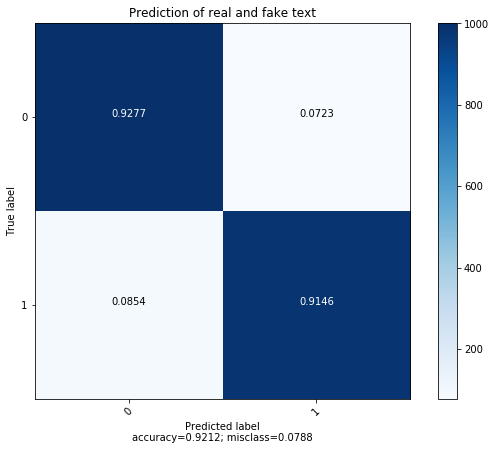

In [11]:
novs = combined_data['novelty'].values
divs = combined_data['diversity'].values

x = list()
for ix, nov in enumerate(novs):
    x.append([nov, divs[ix]])

x_train, test, train_labels, test_labels = train_test_split(x, y, test_size = 0.10)

print('input dimensions:', len(x), '|', 'output dimensions:', len(y))
print('x_train dimensions:', len(x_train), '|', 'y_train dimensions:', len(train_labels))
print('x_test dimensions:', len(test), '|', 'y_test dimensions:', len(test_labels)) 

# Initialize classifier
rfc = RandomForestClassifier()

# Train classifier
model = rfc.fit(x_train, train_labels)

# Make predictions
y_preds = rfc.predict(test)

# Evaluate model
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(test_labels, y_preds))
print(accuracy_score(test_labels, y_preds))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_labels, y_preds))


plot_confusion_matrix(cm           = confusion_matrix(test_labels, y_preds),                  # confusion matrix created by
                                                          # sklearn.metrics.confusion_matrix
                      normalize    = True,                # show proportions
                      target_names = [0, 1],       # list of names of the classes
                      title        = 'Prediction of real and fake text') # title of graph

## Classify using only novelty

input dimensions: 21554 | output dimensions: 21554
x_train dimensions: 19398 | y_train dimensions: 19398
x_test dimensions: 2156 | y_test dimensions: 2156
             precision    recall  f1-score   support

          0       0.65      0.73      0.69      1107
          1       0.68      0.59      0.63      1049

avg / total       0.66      0.66      0.66      2156

0.6628014842300557
[[809 298]
 [429 620]]


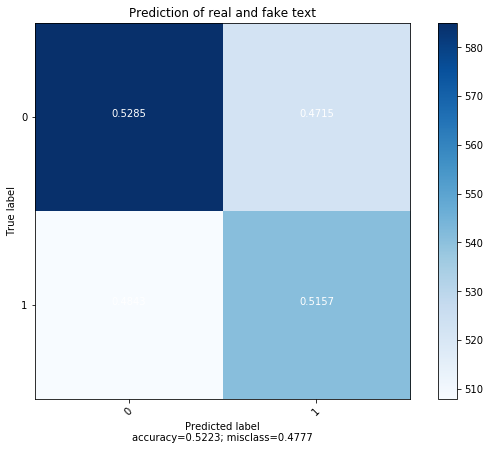

In [12]:
novs = combined_data['novelty'].values

x = []
for ix, nov in enumerate(novs):
    x.append([nov])

x_train, test, train_labels, test_labels = train_test_split(x, y, test_size = 0.10)

print('input dimensions:', len(x), '|', 'output dimensions:', len(y))
print('x_train dimensions:', len(x_train), '|', 'y_train dimensions:', len(train_labels))
print('x_test dimensions:', len(test), '|', 'y_test dimensions:', len(test_labels)) 

# Initialize classifier
rfc = RandomForestClassifier()

# Train classifier
model = rfc.fit(x_train, train_labels)

# Make predictions
preds = rfc.predict(test)

# Evaluate model
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(test_labels, preds))
print(accuracy_score(test_labels, preds))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_labels, preds))


plot_confusion_matrix(cm           = confusion_matrix(test_labels, y_preds),                  # confusion matrix created by
                                                          # sklearn.metrics.confusion_matrix
                      normalize    = True,                # show proportions
                      target_names = [0, 1],       # list of names of the classes
                      title        = 'Prediction of real and fake text') # title of graph

## Classify using only diversity

In [13]:
divs = combined_data['diversity'].values

x = []
for ix, div in enumerate(divs):
    x.append([div])

x_train, test, train_labels, test_labels = train_test_split(x, y, test_size = 0.10)

print('input dimensions:', len(x), '|', 'output dimensions:', len(y))
print('x_train dimensions:', len(x_train), '|', 'y_train dimensions:', len(train_labels))
print('x_test dimensions:', len(test), '|', 'y_test dimensions:', len(test_labels)) 

# Initialize classifier
rfc = RandomForestClassifier()

# Train classifier
model = rfc.fit(x_train, train_labels)

# Make predictions
preds = rfc.predict(test)

# Evaluate model
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(test_labels, preds))
print(accuracy_score(test_labels, preds))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_labels, preds))

input dimensions: 21554 | output dimensions: 21554
x_train dimensions: 19398 | y_train dimensions: 19398
x_test dimensions: 2156 | y_test dimensions: 2156
             precision    recall  f1-score   support

          0       0.86      0.91      0.88      1085
          1       0.90      0.85      0.87      1071

avg / total       0.88      0.88      0.88      2156

0.87569573283859
[[982 103]
 [165 906]]


## Classify with both novelty and diversity: test with unseen data (TBD)

In [14]:
novs = combined_data['novelty'].values
divs = combined_data['diversity'].values

x = list()
for ix, nov in enumerate(novs):
    x.append([nov, divs[ix]])
    
# unlabelled_real='unlabelled_real_text.csv' # not really unlabelled, just missing novelty and diversity
# unlabelled_fake='unlabelled_fake_text.csv' # same here

# _real_data = pd.read_csv(unlabelled_real)
# _fake_data = pd.read_csv(unlabelled_real)

# _combined_data = _real_data.append(_fake_data)

# x_train, test, train_labels, test_labels = x,  , y, _combined_data['label'].values

x_train, test, train_labels, test_labels = train_test_split(x, y, test_size = 0.10)

print('input dimensions:', len(x), '|', 'output dimensions:', len(y))
print('x_train dimensions:', len(x_train), '|', 'y_train dimensions:', len(train_labels))
print('x_test dimensions:', len(test), '|', 'y_test dimensions:', len(test_labels)) 

# Initialize classifier
rfc = RandomForestClassifier()

# Train classifier
model = rfc.fit(x_train, train_labels)

# Make predictions
preds = rfc.predict(test)

# Evaluate model
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(test_labels, preds))
print(accuracy_score(test_labels, preds))

input dimensions: 21554 | output dimensions: 21554
x_train dimensions: 19398 | y_train dimensions: 19398
x_test dimensions: 2156 | y_test dimensions: 2156
             precision    recall  f1-score   support

          0       0.91      0.92      0.92      1062
          1       0.93      0.91      0.92      1094

avg / total       0.92      0.92      0.92      2156

0.9188311688311688
